## Deliverable 1

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_5234/343254398.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(x=combined.index, y=combined.values, palette="Blues_d")
/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_5234/343254398.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


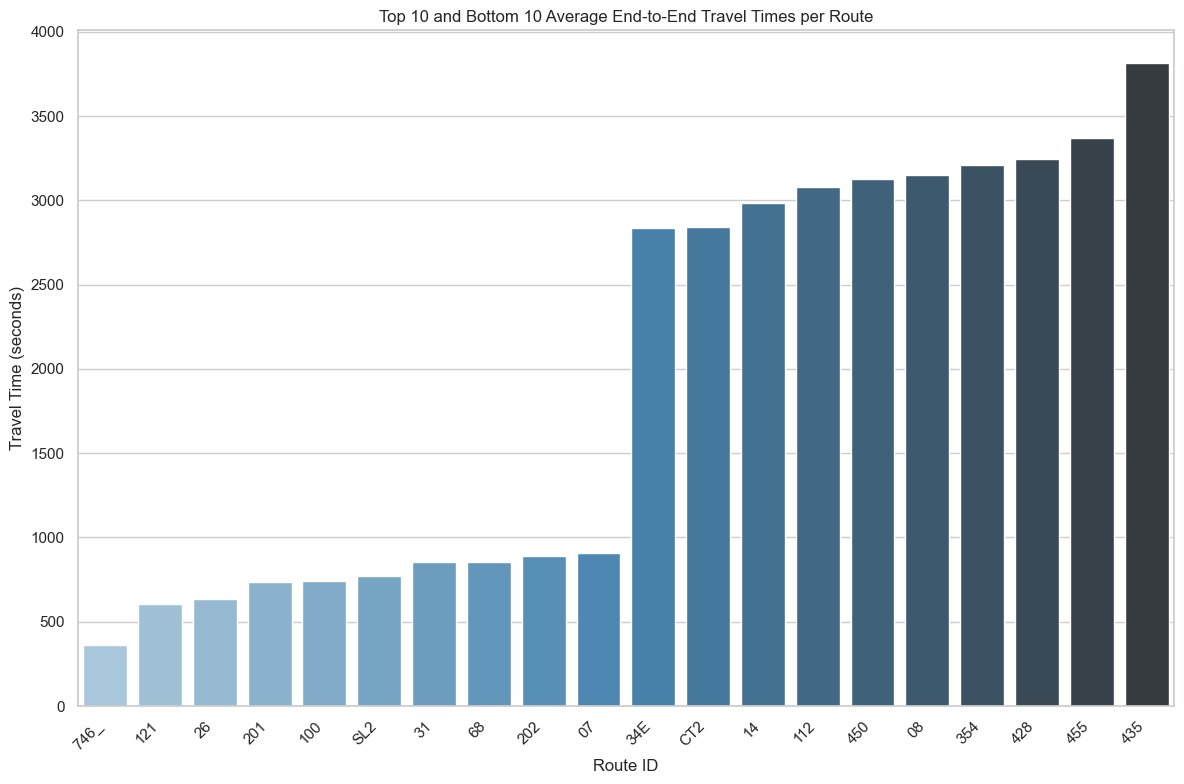

In [1]:
#visual graph of end to end service times for month of January 2022
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_end_to_end_time(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['actual', 'scheduled'])

    # Filter rows for start and end points only
    df_filtered = df[df['point_type'].isin(['Startpoint', 'Endpoint'])]

    # Group by route_id, half_trip_id, and then apply a diff function on actual time
    df_filtered = df_filtered.sort_values(by=['route_id', 'half_trip_id', 'actual'])
    df_filtered['travel_time'] = df_filtered.groupby(['route_id', 'half_trip_id'])['actual'].diff()

    # Only keep the endpoint rows which now contain the travel time in the 'travel_time' column
    df_endpoints = df_filtered[df_filtered['point_type'] == 'Endpoint']

    # Calculate mean travel time for each route
    result = df_endpoints.groupby('route_id')['travel_time'].mean()

    # Convert travel time to total seconds for plotting
    result_seconds = result.dt.total_seconds()

    return result_seconds

def plot_travel_times(result_seconds):
    # Sort the results
    sorted_times = result_seconds.sort_values()

    # Select top 10 and bottom 10 routes
    top_10 = sorted_times.head(10)
    bottom_10 = sorted_times.tail(10)

    # Concatenate top 10 and bottom 10 for plotting
    combined = pd.concat([top_10, bottom_10])

    # Create a bar chart using seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    chart = sns.barplot(x=combined.index, y=combined.values, palette="Blues_d")

    # Set chart title and labels
    chart.set_title('Top 10 and Bottom 10 Average End-to-End Travel Times per Route')
    chart.set_ylabel('Travel Time (seconds)')
    chart.set_xlabel('Route ID')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Save and show the chart
    plt.tight_layout()
    plt.savefig('top_bottom_travel_times_chart.png')
    plt.show()

def calculate_average_travel_times(filenames):
    # Initialize a DataFrame to store the sum of travel times and count for averaging
    total_travel_times = pd.Series(dtype=float)
    count = 0

    # Process each file
    for file in filenames:
        travel_times = calculate_end_to_end_time(file)
        if total_travel_times.empty:
            total_travel_times = travel_times
        else:
            # Sum up the travel times for averaging later
            total_travel_times = total_travel_times.add(travel_times, fill_value=0)
        count += 1

    # Calculate the average
    average_travel_times = total_travel_times / count
    return average_travel_times

# List of filenames for each month
filenames = [f'MBTA-Bus-Arrival-Departure-Times_2022-{month:02d}.csv' for month in range(1, 13)]

# Calculate average travel times across all months
average_travel_times = calculate_average_travel_times(filenames)

# Plot the average travel times
plot_travel_times(average_travel_times)

In [2]:
#Calculates the end to end times in hours:minutes:seconds format and cleans all null values and stores them in coorsponding .csv files for each month

import pandas as pd

def calculate_end_to_end_time(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])

    # Filter rows where actual is not NaN
    df = df.dropna(subset=['actual'])

    # Calculate travel time for each trip
    df_grouped = df.groupby(['service_date', 'route_id', 'direction_id', 'half_trip_id'])

    # Finding the difference between the last and first actual time for each trip
    travel_time = df_grouped['actual'].max() - df_grouped['actual'].min()

    # Average travel time per route
    average_travel_time = travel_time.groupby('route_id').mean()

    return average_travel_time

def save_to_csv(result, month):
    # Convert the travel time to hours:minutes:seconds format and filter NaN values
    formatted_result = result.dt.total_seconds().dropna().apply(lambda x: f"{int(x // 3600)}:{int((x % 3600) // 60)}:{int(x % 60)}")
    formatted_result.to_csv(f'end_to_end_times_{month}.csv', header=['Average Travel Time'])

# Iterate through all months
for month in range(1, 13):
    filename = f'MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    travel_times = calculate_end_to_end_time(filename)
    save_to_csv(travel_times, month)


In [3]:
#Calculates the lateness as a percentage and outputs to .csv file
import pandas as pd

def calculate_lateness(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])

    # Calculate if the bus is late
    df['late'] = (df['actual'] - df['scheduled']).dt.total_seconds() > 0

    # Group by route_id and calculate the percentage of times it's late
    route_lateness = df.groupby('route_id')['late'].mean() * 100

    return route_lateness

def save_to_csv(result):
    result.to_csv('average_route_lateness_percent_2022.csv', header=['Average Lateness Percentage'])

all_route_lateness = []

# Iterate through all months
for month in range(1,2):
    filename = f'MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    lateness = calculate_lateness(filename)
    all_route_lateness.append(lateness)

# Combine all the monthly results and calculate the average for the year
average_lateness = pd.concat(all_route_lateness, axis=1).mean(axis=1)
save_to_csv(average_lateness)


In [4]:
#Calculates the lateness by seconds and outputs to .csv file (used for visual element)

import pandas as pd
import matplotlib.pyplot as plt

def calculate_lateness(filename):
    # Read the CSV file
    df = pd.read_csv(filename, parse_dates=['scheduled', 'actual'])
    
    # Calculate lateness for each trip
    df['lateness'] = (df['actual'] - df['scheduled']).dt.total_seconds()
    
    # Average lateness per route
    average_lateness = df.groupby('route_id')['lateness'].mean()
    
    return average_lateness

def save_lateness_to_csv(result):
    result.to_csv('average_route_lateness_seconds_2022.csv', header=['Average Lateness'])

# Calculate average lateness
all_lateness_data = []
for month in range(1, 13):
    filename = f'MBTA-Bus-Arrival-Departure-Times_2022-{month:02}.csv'
    lateness = calculate_lateness(filename)
    all_lateness_data.append(lateness)

# Combine monthly data and compute overall average for the year
total_lateness = pd.concat(all_lateness_data, axis=1).mean(axis=1)
save_lateness_to_csv(total_lateness)


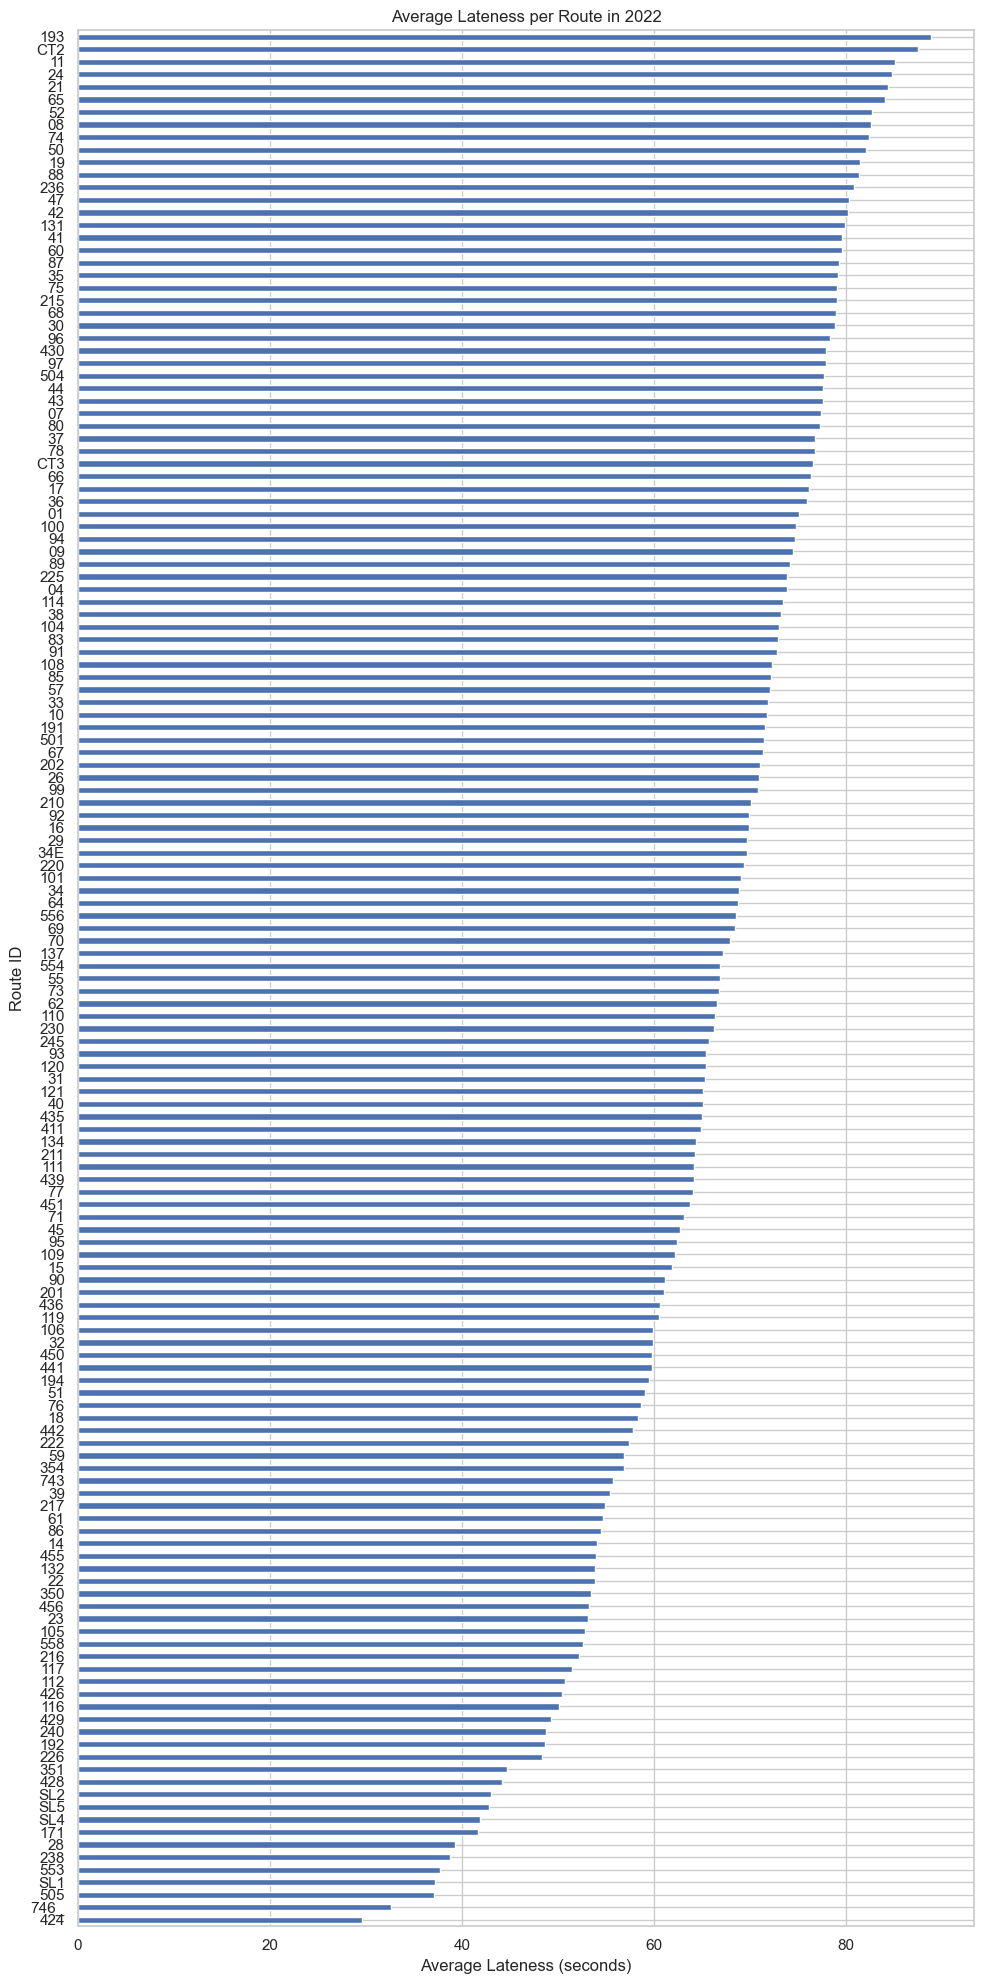

In [5]:
#Visual graph of average lateness for year of 2022 by bus route id's
def visualize_lateness():
    # Read the lateness data
    lateness_df = pd.read_csv('average_route_lateness_percent_2022.csv', index_col='route_id')
    
    # Plot
    lateness_df.sort_values(by='Average Lateness Percentage', ascending=True).plot(kind='barh', figsize=(10, 20), legend=False)
    plt.title('Average Lateness per Route in 2022')
    plt.xlabel('Average Lateness (seconds)')
    plt.ylabel('Route ID')
    plt.tight_layout()
    plt.savefig('average_route_lateness_2022_plot.png')
    plt.show()

visualize_lateness()


## Deliverable 2

In [13]:
avg_lateness = pd.read_csv('average_route_lateness_percent_2022.csv')

bus_stops = pd.read_csv('MBTA_Systemwide_GTFS_Map.csv')
bus_stops.reset_index(inplace=True)

population_data = pd.read_csv('redistricting_data_tract20_nbhd_hhpopsize_ab-1.csv')
population_data.columns = population_data.iloc[0]
population_data.columns = population_data.columns.str.replace(':', '')
population_data = population_data.drop(population_data.index[0])
population_data = population_data.reset_index(drop=True)
population_data = population_data.rename(columns={population_data.columns[0]: 'Neighborhood'})

In [14]:
population_data.columns.values[1] = 'Total population, all ages'
population_data.columns.values[2] = 'White alone, all ages'
population_data.columns.values[3] = 'Black or African American alone, all ages'
population_data.columns.values[4] = 'Hispanic or Latino, all ages'
population_data.columns.values[7] = 'Total_population, aged 18+'
population_data.columns.values[8] = 'White alone, aged 18+'
population_data.columns.values[9] = 'Black or African American alone, aged 18+'
population_data.columns.values[10] = 'Hispanic or Latino, aged 18+'
population_data.columns.values[20] = 'Total_population, institutionalization'
population_data.drop(columns=['Total', 'Occupied', 'Vacant', 'household population', 'household size'], inplace=True)

In [15]:
pd.set_option('display.max_columns', None)
pd.DataFrame(population_data)

,Neighborhood,"Total population, all ages","White alone, all ages","Black or African American alone, all ages","Hispanic or Latino, all ages","Asian, Native Hawaiian and Pacific Islander alone, all ages","Other Races or Multiple Races, all ages","Total_population, aged 18+","White alone, aged 18+","Black or African American alone, aged 18+","Hispanic or Latino, aged 18+","Asian, Native Hawaiian and Pacific Islander alone, aged 18+","Other Races or Multiple Races, aged 18+",Total aged 0-17,"White alone, aged 0-17","Black or African American alone, aged 0-17","Hispanic or Latino, aged 0-17","Asian, Native Hawaiian and Pacific Islander alone, aged 0-17","Other Races or Multiple Races, aged 0-17","Total_population, institutionalization",Institutionalized population,Correctional facilities for adults,Juvenile facilities,Nursing facilities/Skilled-nursing facilities,Other institutional facilities,Noninstitutionalized population,College/University student housing,Military quarters,Other noninstitutional facilities
0,Allston,24904,12536,1326,3259,6271,1512,23140,11976,1184,2726,5960,1294,1764,560,142,533,311,218,3281,0,0,0,0,0,3281,3214,0,67
1,Back Bay,18190,13065,690,1208,2410,817,17042,12349,641,1091,2290,671,1148,716,49,117,120,146,1879,269,0,0,269,0,1610,1487,0,123
2,Beacon Hill,9336,7521,252,537,630,396,8603,6980,231,475,615,302,733,541,21,62,15,94,33,0,0,0,0,0,33,0,0,33
3,Brighton,52047,32694,2414,5376,8703,2860,47657,30752,2076,4388,8082,2359,4390,1942,338,988,621,501,4131,335,0,13,266,56,3796,3493,0,303
4,Charlestown,19120,13626,990,2075,1650,779,15661,11689,662,1387,1404,519,3459,1937,328,688,246,260,110,55,0,0,55,0,55,0,30,25
5,Chinatown,6211,1844,254,451,3480,182,5477,1741,216,390,2971,159,734,103,38,61,509,23,446,0,0,0,0,0,446,443,0,3
6,Dorchester,122191,27411,42714,25285,13360,13421,95365,24327,32678,17390,10875,10095,26826,3084,10036,7895,2485,3326,1513,577,0,286,291,0,936,0,0,936
7,Downtown,13768,8730,569,967,3018,484,12975,8340,559,888,2817,371,793,390,10,79,201,113,4445,321,0,0,321,0,4124,3283,0,841
8,East Boston,43066,15760,1403,21700,1932,2271,34826,14039,1136,16256,1714,1681,8240,1721,267,5444,218,590,253,144,0,12,132,0,109,0,0,109
9,Fenway,37493,20350,2333,3565,9210,2035,36437,19950,2231,3353,9005,1898,1056,400,102,212,205,137,15483,314,53,0,261,0,15169,14960,0,209


In [24]:
# simple imputation
bus_stops_expanded = bus_stops.assign(Routes=bus_stops['Routes'].str.split('|')).explode('Routes')
for column in bus_stops_expanded.columns:
    if bus_stops_expanded[column].dtype == 'object':
        bus_stops_expanded[column].fillna('None', inplace=True)
    else:
        mode_value = bus_stops_expanded[column].mode()[0]
        bus_stops_expanded[column].fillna(mode_value, inplace=True)

In [17]:
bus_stops_with_population = pd.merge(bus_stops_expanded, population_data, on='Neighborhood', how='left')

route_population_characteristics = bus_stops_with_population.groupby('Routes').agg({
    'Total population, all ages': 'sum',
    'White alone, all ages': 'sum',
    'Black or African American alone, all ages': 'sum',
    'Hispanic or Latino, all ages': 'sum',
    'Asian, Native Hawaiian and Pacific Islander alone, all ages': 'sum',
    'Other Races or Multiple Races,  all ages': 'sum',
    'Total_population, aged 18+': 'sum', 
    'White alone, aged 18+': 'sum',
    'Black or African American alone, aged 18+': 'sum',
    'Hispanic or Latino, aged 18+': 'sum',
    'Asian, Native Hawaiian and Pacific Islander alone, aged 18+': 'sum',
    'Other Races or Multiple Races, aged 18+': 'sum', 
    'Total aged 0-17': 'sum',
    'White alone, aged 0-17': 'sum',
    'Black or African American alone, aged 0-17': 'sum',
    'Hispanic or Latino, aged 0-17': 'sum',
    'Asian, Native Hawaiian and Pacific Islander alone, aged 0-17': 'sum',
    'Other Races or Multiple Races, aged 0-17': 'sum', 
    'Total_population, institutionalization': 'sum', 
    'Institutionalized population': 'sum',
    'Correctional facilities for adults': 'sum', 
    'Juvenile facilities': 'sum',
    'Nursing facilities/Skilled-nursing facilities': 'sum',
    'Other institutional facilities': 'sum',
    'Noninstitutionalized population': 'sum',
    'College/University student housing': 'sum', 
    'Military quarters': 'sum',
    'Other noninstitutional facilities': 'sum', 
}).reset_index()

route_service_analysis = pd.merge(route_population_characteristics, avg_lateness, left_on='Routes', right_on='route_id', how='left')

In [ ]:
# base question 3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sorted_data = route_service_analysis.sort_values(by='Total population, all ages', ascending=False)
top_routes = sorted_data['Routes'].head(20)
selected_data = selected_data = sorted_data.head(20)#route_service_analysis[route_service_analysis['Routes'].isin(top_routes)]

plt.figure(figsize=(10, 6))
sns.barplot(x='Routes', y='Total population, all ages', data=selected_data)
plt.title('Top 20 Total Population Serviced by Bus Routes')
plt.show()

# race characteristics
race_columns = ['White alone, all ages', 'Black or African American alone, all ages', 
                'Hispanic or Latino, all ages', 'Asian, Native Hawaiian and Pacific Islander alone, all ages', 
                'Other Races or Multiple Races,  all ages']

selected_data_normalized = selected_data.copy()
selected_data_normalized[race_columns] = selected_data_normalized[race_columns].div(selected_data_normalized['Total population, all ages'], axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(selected_data))

for col in race_columns:
    ax.bar(selected_data['Routes'], selected_data_normalized[col], bottom=bottom, label=col)
    bottom += selected_data_normalized[col].values

ax.set_title('Race and Ethnicity Composition Serviced by Top 20 Bus Routes)')
ax.set_xlabel('Routes')
ax.set_ylabel('Proportion of Population')
ax.legend()
plt.show()



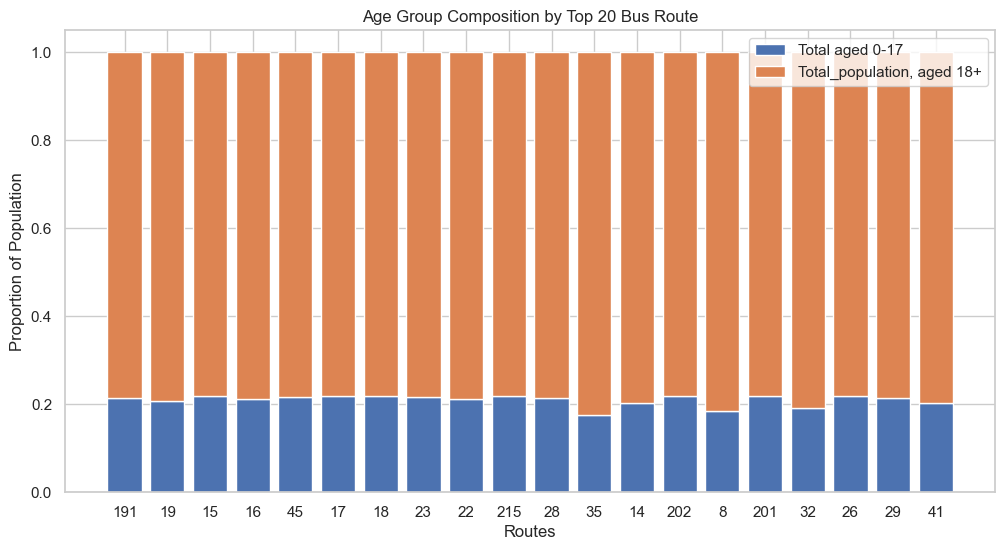

In [ ]:
# age-related columns
age_columns = ['Total aged 0-17', 'Total_population, aged 18+']

# normalizing data for stacked chart
selected_data_normalized[age_columns] = selected_data_normalized[age_columns].div(selected_data_normalized['Total population, all ages'], axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(selected_data))

for col in age_columns:
    ax.bar(selected_data['Routes'], selected_data_normalized[col], bottom=bottom, label=col)
    bottom += selected_data_normalized[col].values

ax.set_title('Age Group Composition by Top 20 Bus Route')
ax.set_xlabel('Routes')
ax.set_ylabel('Proportion of Population')
ax.legend()
plt.show()


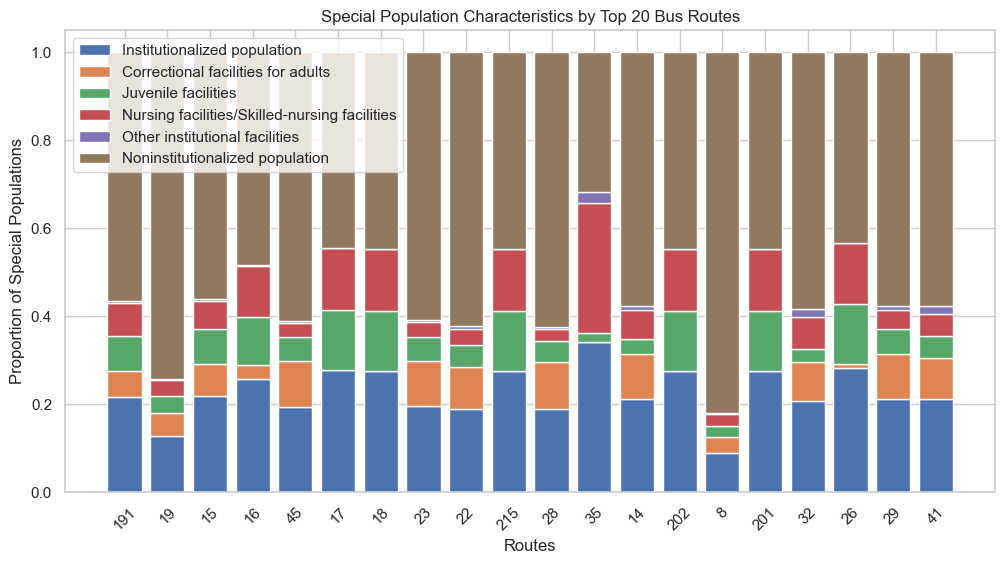

In [ ]:
# Special Populations
special_population_columns = [
    'Institutionalized population',
    'Correctional facilities for adults',
    'Juvenile facilities',
    'Nursing facilities/Skilled-nursing facilities',
    'Other institutional facilities',
    'Noninstitutionalized population'
]

special_population_sum = selected_data_normalized[special_population_columns].sum(axis=1)
selected_data_normalized[special_population_columns] = selected_data_normalized[special_population_columns].div(special_population_sum, axis=0)

plt.figure(figsize=(12, 6))
bottom_val = np.zeros(len(selected_data_normalized))

for col in special_population_columns:
    plt.bar(selected_data_normalized['Routes'], selected_data_normalized[col], bottom=bottom_val, label=col)
    bottom_val += selected_data_normalized[col].values

plt.title('Special Population Characteristics by Top 20 Bus Routes')
plt.xlabel('Routes')
plt.ylabel('Proportion of Special Populations')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()


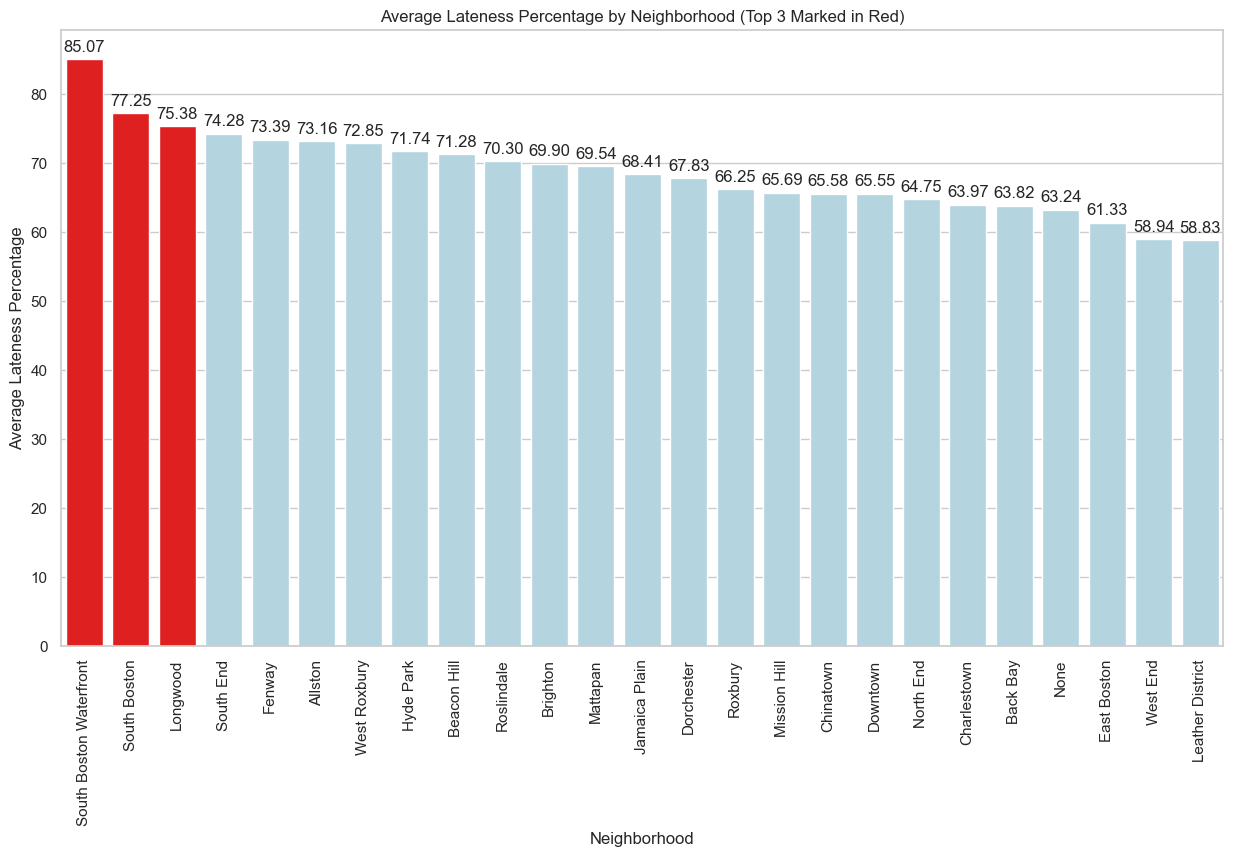

In [ ]:
# base question 5: which neighborhoods are served better/worse by the MTBA bus system? 
# explore potential service disparity by Neighborhood to see which are better or worse served
all_merged = pd.merge(bus_stops_with_population, avg_lateness, left_on='Routes', right_on='route_id', how='left')
neighborhood_service_analysis = all_merged.groupby('Neighborhood').agg({
    'Average Lateness Percentage': 'mean'
}).reset_index()
neighborhood_service_analysis = neighborhood_service_analysis.dropna(subset=['Average Lateness Percentage'])
neighborhood_service_analysis = neighborhood_service_analysis.sort_values('Average Lateness Percentage', ascending=False)

colors = ['red' if i < 3 else '#add8e6' for i in range(len(neighborhood_service_analysis))]

plt.figure(figsize=(15, 8))
barplot = sns.barplot(x='Neighborhood', y='Average Lateness Percentage', 
                      hue='Neighborhood', data=neighborhood_service_analysis, 
                      legend=False, palette=colors)
plt.title('Average Lateness Percentage by Neighborhood (Top 3 Marked in Red)')
plt.xticks(rotation=90)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

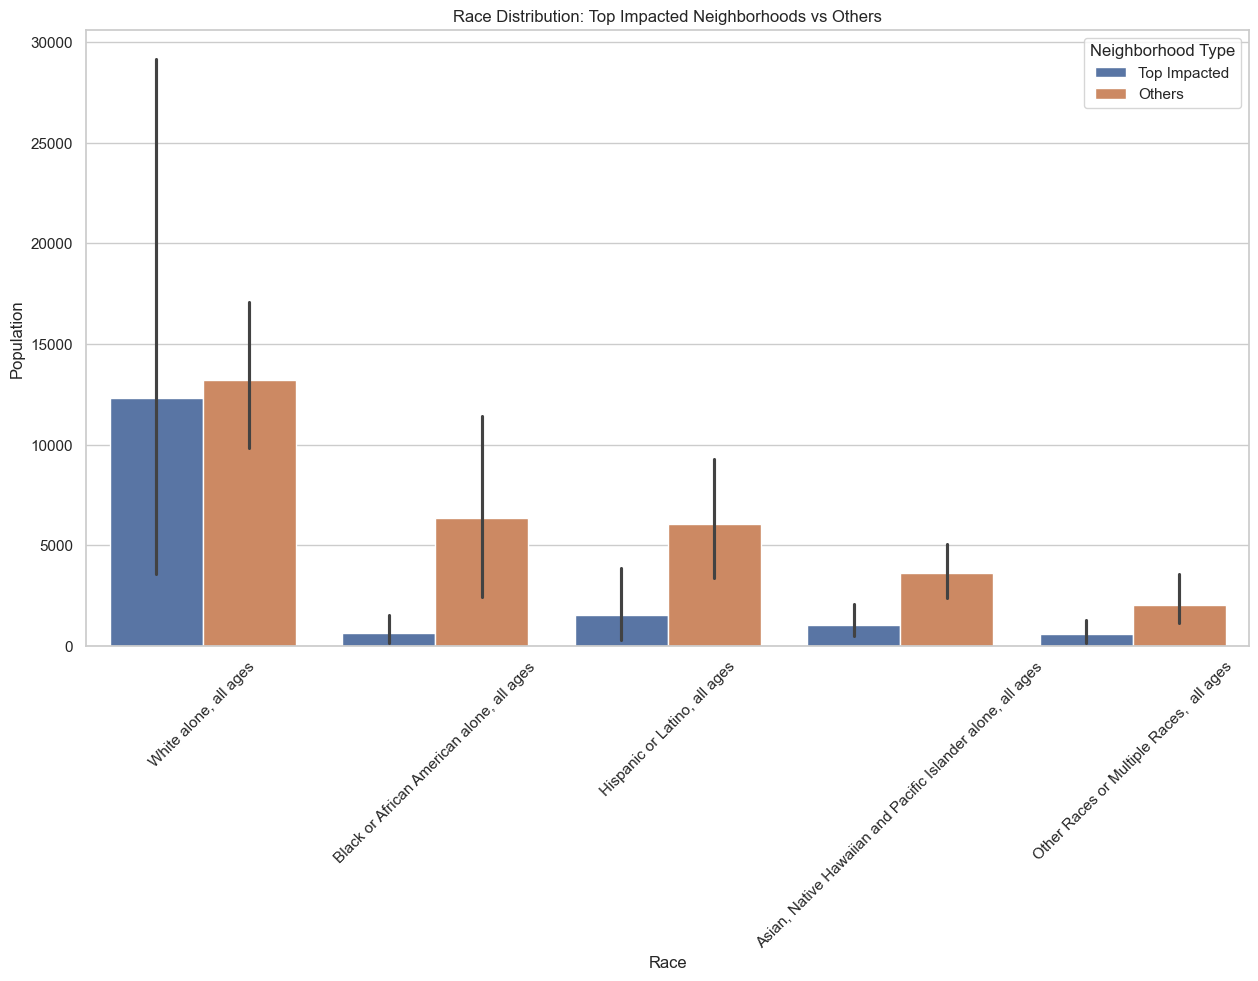

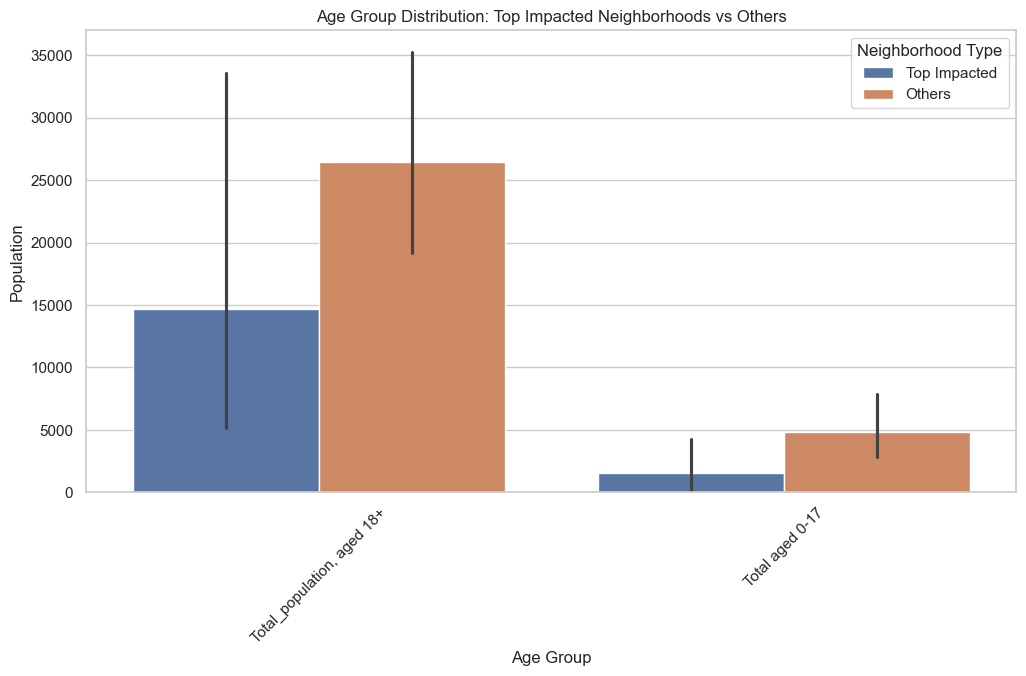

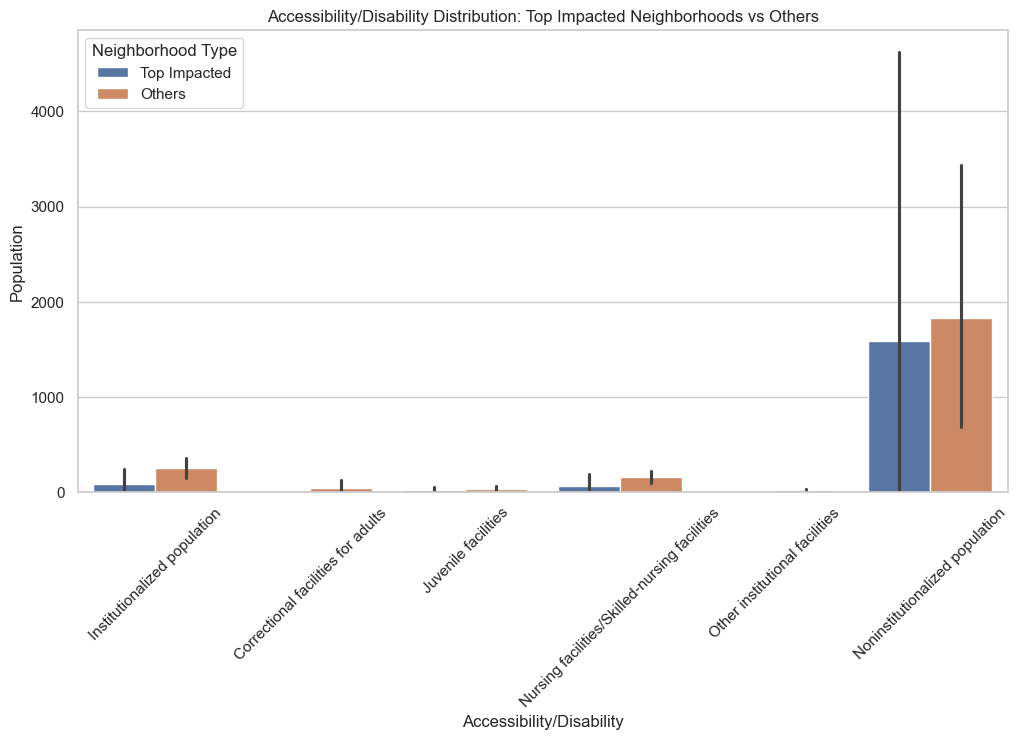

In [ ]:
# base question 4
# explore the characteristics of people (race, age, people with accessibility/vulnerability)
# in the most impacted neighborhoods

top_impacted_neighborhoods = neighborhood_service_analysis.head(3)['Neighborhood']
top_demographics = population_data[population_data['Neighborhood'].isin(top_impacted_neighborhoods)]
other_demographics = population_data[~population_data['Neighborhood'].isin(top_impacted_neighborhoods)]

race_columns = ['White alone, all ages', 'Black or African American alone, all ages', 'Hispanic or Latino, all ages', 
                'Asian, Native Hawaiian and Pacific Islander alone, all ages', 'Other Races or Multiple Races,  all ages']

top_demographics_long = pd.melt(top_demographics, id_vars=['Neighborhood'], value_vars=race_columns, 
                                var_name='Race', value_name='Population')
other_demographics_long = pd.melt(other_demographics, id_vars=['Neighborhood'], value_vars=race_columns, 
                                  var_name='Race', value_name='Population')

top_demographics_long['Type'] = 'Top Impacted'
other_demographics_long['Type'] = 'Others'

combined_demographics = pd.concat([top_demographics_long, other_demographics_long])

plt.figure(figsize=(15, 8))
sns.barplot(x='Race', y='Population', hue='Type', data=combined_demographics)
plt.title('Race Distribution: Top Impacted Neighborhoods vs Others')
plt.xticks(rotation=45)
plt.xlabel('Race')
plt.ylabel('Population')
plt.legend(title='Neighborhood Type')
plt.show()

age_columns = ['Total_population, aged 18+', 'Total aged 0-17']
top_age_long = pd.melt(top_demographics, id_vars=['Neighborhood'], value_vars=age_columns, 
                       var_name='Age Group', value_name='Population')
other_age_long = pd.melt(other_demographics, id_vars=['Neighborhood'], value_vars=age_columns, 
                         var_name='Age Group', value_name='Population')

accessibility_columns = [
    'Institutionalized population',
    'Correctional facilities for adults',
    'Juvenile facilities',
    'Nursing facilities/Skilled-nursing facilities',
    'Other institutional facilities',
    'Noninstitutionalized population'
]
top_accessibility_long = pd.melt(top_demographics, id_vars=['Neighborhood'], value_vars=accessibility_columns, 
                                 var_name='Accessibility/Disability', value_name='Population')
other_accessibility_long = pd.melt(other_demographics, id_vars=['Neighborhood'], value_vars=accessibility_columns, 
                                   var_name='Accessibility/Disability', value_name='Population')

top_age_long['Type'] = 'Top Impacted'
other_age_long['Type'] = 'Others'
top_accessibility_long['Type'] = 'Top Impacted'
other_accessibility_long['Type'] = 'Others'

combined_age = pd.concat([top_age_long, other_age_long])
combined_accessibility = pd.concat([top_accessibility_long, other_accessibility_long])

plt.figure(figsize=(12, 6))
sns.barplot(x='Age Group', y='Population', hue='Type', data=combined_age)
plt.title('Age Group Distribution: Top Impacted Neighborhoods vs Others')
plt.xticks(rotation=45)
plt.xlabel('Age Group')
plt.ylabel('Population')
plt.legend(title='Neighborhood Type')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Accessibility/Disability', y='Population', hue='Type', data=combined_accessibility)
plt.title('Accessibility/Disability Distribution: Top Impacted Neighborhoods vs Others')
plt.xticks(rotation=45)
plt.xlabel('Accessibility/Disability')
plt.ylabel('Population')
plt.legend(title='Neighborhood Type')
plt.show()



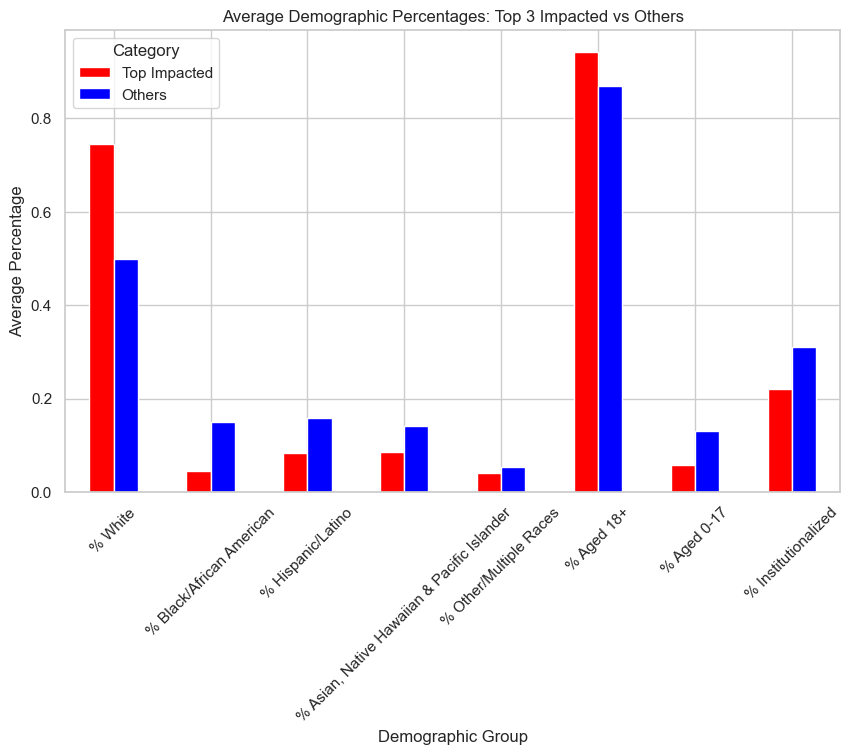

In [ ]:
# base question 4: If there are service level disparities, are there differences in the characteristics of the people most impacted? 
# the average percentage for each demographic in top impacted neighborhoods
top_demographics.loc[:,'Total population'] = top_demographics['Total population, all ages']
top_demographics.loc[:,'% White'] = top_demographics['White alone, all ages'] / top_demographics['Total population']
top_demographics.loc[:,'% Black/African American'] = top_demographics['Black or African American alone, all ages'] / top_demographics['Total population']
top_demographics.loc[:,'% Hispanic/Latino'] = top_demographics['Hispanic or Latino, all ages'] / top_demographics['Total population']
top_demographics.loc[:,'% Asian, Native Hawaiian & Pacific Islander'] = top_demographics['Asian, Native Hawaiian and Pacific Islander alone, all ages'] / top_demographics['Total population']
top_demographics.loc[:,'% Other/Multiple Races'] = top_demographics['Other Races or Multiple Races,  all ages'] / top_demographics['Total population']
top_demographics.loc[:,'% Aged 18+'] = top_demographics['Total_population, aged 18+'] / top_demographics['Total population']
top_demographics.loc[:,'% Aged 0-17'] = top_demographics['Total aged 0-17'] / top_demographics['Total population']
top_demographics.loc[:,'% Institutionalized'] = top_demographics['Institutionalized population'] / top_demographics['Total_population, institutionalization']

# Calculate the average percentage for each demographic in other neighborhoods
other_demographics.loc[:,'Total population'] = other_demographics['Total population, all ages']
other_demographics.loc[:,'% White'] = other_demographics['White alone, all ages'] / other_demographics['Total population']
other_demographics.loc[:,'% Black/African American'] = other_demographics['Black or African American alone, all ages'] / other_demographics['Total population']
other_demographics.loc[:,'% Hispanic/Latino'] = other_demographics['Hispanic or Latino, all ages'] / other_demographics['Total population']
other_demographics.loc[:,'% Asian, Native Hawaiian & Pacific Islander'] = other_demographics['Asian, Native Hawaiian and Pacific Islander alone, all ages'] / other_demographics['Total population']
other_demographics.loc[:,'% Other/Multiple Races'] = other_demographics['Other Races or Multiple Races,  all ages'] / other_demographics['Total population']
other_demographics.loc[:,'% Aged 18+'] = other_demographics['Total_population, aged 18+'] / other_demographics['Total population']
other_demographics.loc[:,'% Aged 0-17'] = other_demographics['Total aged 0-17'] / other_demographics['Total population']
other_demographics.loc[:,'% Institutionalized'] = other_demographics['Institutionalized population'] / other_demographics['Total_population, institutionalization']

# Calculate the average percentages
avg_top_demographics = top_demographics[['% White', '% Black/African American', 
                                        '% Hispanic/Latino', 
                                        '% Asian, Native Hawaiian & Pacific Islander',
                                        '% Other/Multiple Races',
                                        '% Aged 18+',
                                        '% Aged 0-17',
                                        '% Institutionalized']].mean()
avg_other_demographics = other_demographics[['% White', '% Black/African American', 
                                        '% Hispanic/Latino', 
                                        '% Asian, Native Hawaiian & Pacific Islander',
                                        '% Other/Multiple Races',
                                        '% Aged 18+',
                                        '% Aged 0-17',
                                        '% Institutionalized']].mean()

# Combine the data for plotting
avg_demographics = pd.DataFrame({'Top Impacted': avg_top_demographics, 'Others': avg_other_demographics}).reset_index()
avg_demographics.columns.values[0] = 'Demographic'
avg_demographics = avg_demographics.set_index(avg_demographics.columns[0])

ax = avg_demographics.plot(kind='bar', figsize=(10, 6), color=['red', 'blue'])
plt.title('Average Demographic Percentages: Top 3 Impacted vs Others')
plt.xlabel('Demographic Group')
plt.ylabel('Average Percentage')
plt.xticks(rotation=45)
plt.legend(title='Category', loc='upper left', labels=['Top Impacted', 'Others'])
plt.show()


## Deliverable 3

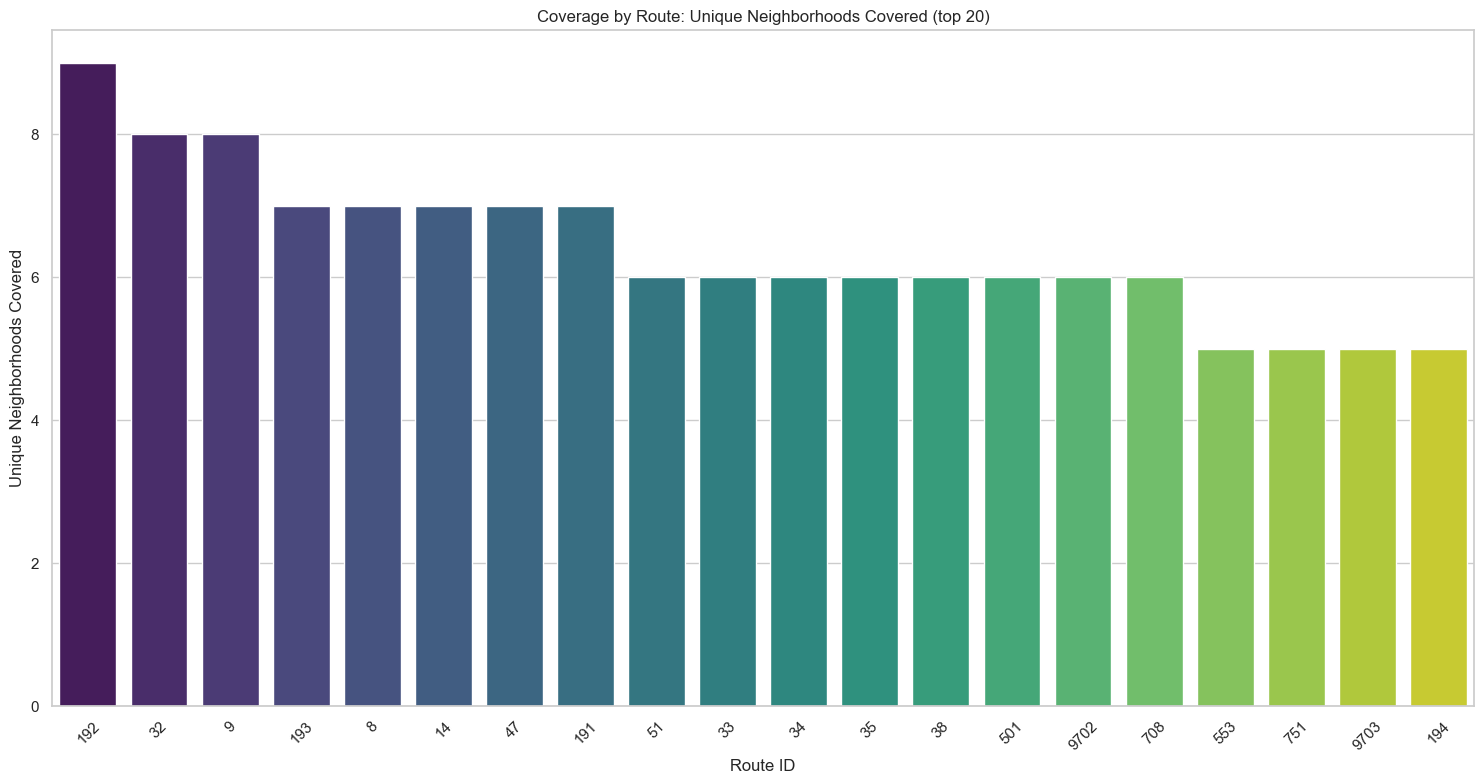

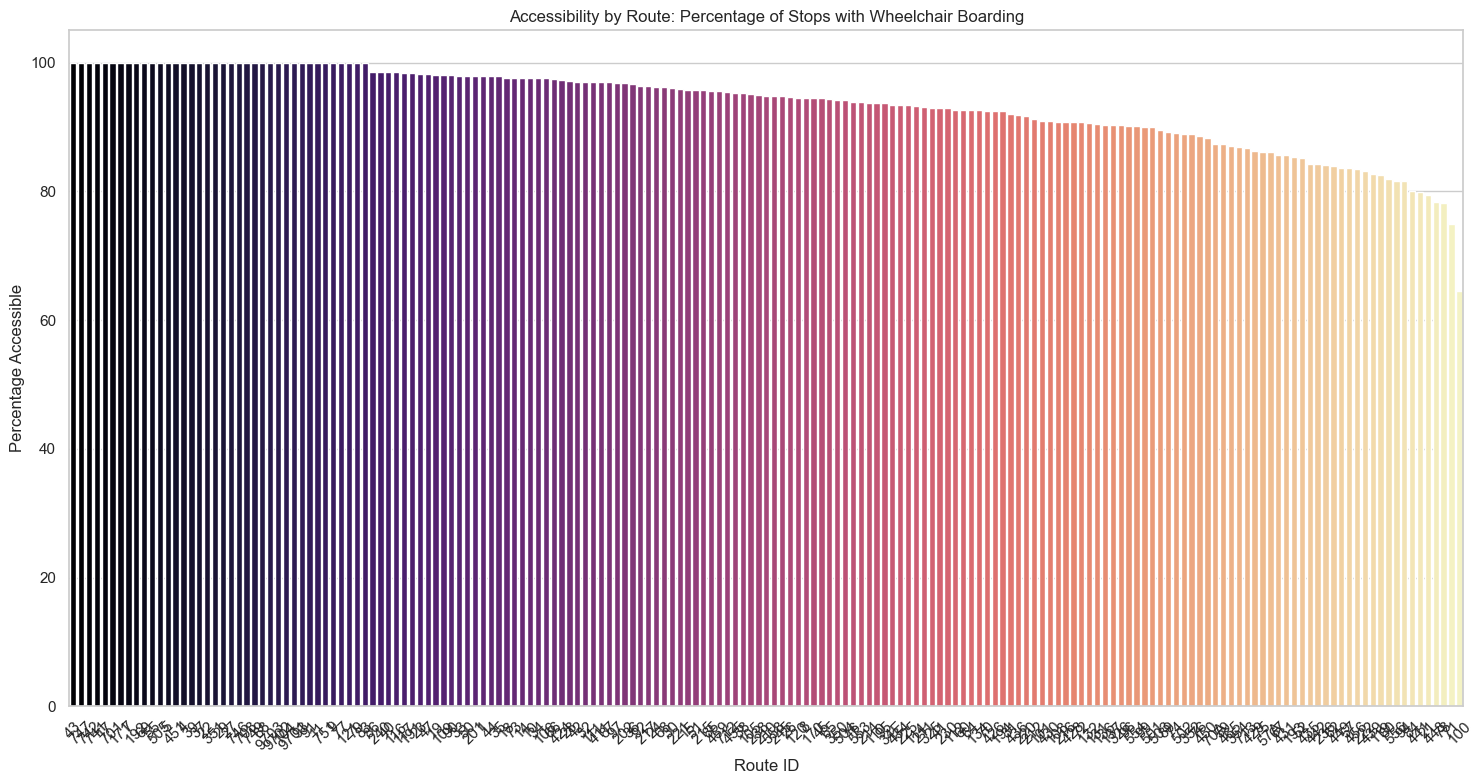

/var/folders/vr/syshz9v92js62ld8ch0rw37r0000gn/T/ipykernel_5234/757669753.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lower_coverage_routes.index, y='Percentage Accessible', data=lower_coverage_routes, palette='coolwarm')


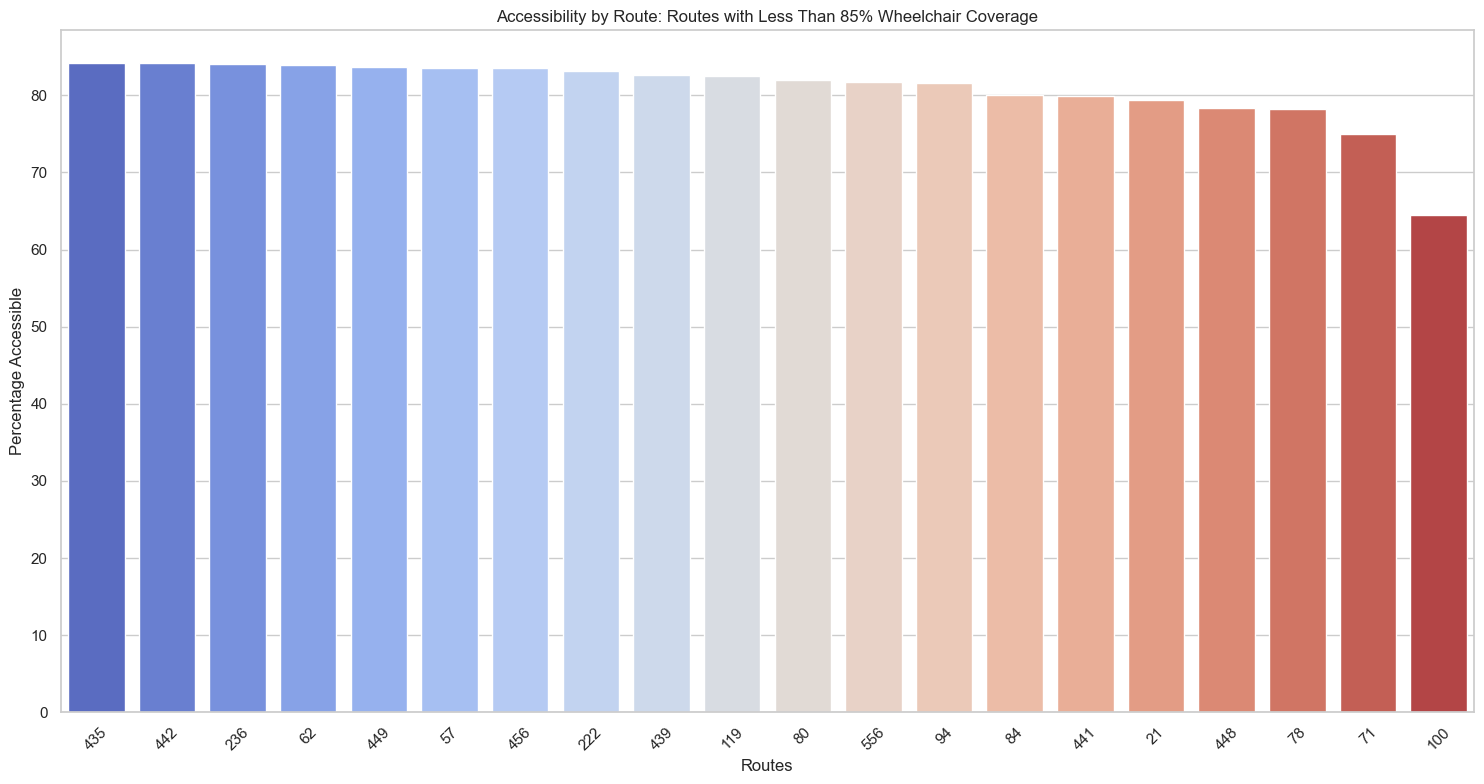

In [29]:
# Coverage and Accessibility: The extent to which a bus route covers different neighborhoods
coverage_by_route = bus_stops_expanded.groupby('Routes')['Neighborhood'].nunique().reset_index()
coverage_by_route.columns = ['Route ID', 'Unique Neighborhoods Covered']

# Accessibility Analysis: count stops with wheelchair boarding by route
accessible_stops_by_route = bus_stops_expanded.groupby(['Routes', 'wheelchair_boarding']).size().unstack(fill_value=0)
accessible_stops_by_route['Total Stops'] = accessible_stops_by_route.sum(axis=1)
accessible_stops_by_route['Percentage Accessible'] = (accessible_stops_by_route[1] / accessible_stops_by_route['Total Stops']) * 100
lower_coverage_routes = accessible_stops_by_route[accessible_stops_by_route['Percentage Accessible'] < 85].sort_values(by='Percentage Accessible', ascending=False)

combined_data = coverage_by_route.merge(accessible_stops_by_route[['Total Stops', 'Percentage Accessible']], left_on='Route ID', right_index=True)
combined_data = combined_data[:-1]
combined_sorted_num_neighborhood = combined_data.sort_values(by='Unique Neighborhoods Covered', ascending=False).head(20)
combined_sorted_wheelchair_perc = combined_data.sort_values(by='Percentage Accessible', ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x='Route ID', y='Unique Neighborhoods Covered', hue='Route ID', data=combined_sorted_num_neighborhood, legend=False, palette='viridis')
plt.title('Coverage by Route: Unique Neighborhoods Covered (top 20)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(x='Route ID', y='Percentage Accessible', hue='Route ID', data=combined_sorted_wheelchair_perc, legend=False, palette='magma')
plt.title('Accessibility by Route: Percentage of Stops with Wheelchair Boarding')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(x=lower_coverage_routes.index, y='Percentage Accessible', data=lower_coverage_routes, palette='coolwarm')
plt.title('Accessibility by Route: Routes with Less Than 85% Wheelchair Coverage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [70]:
accessible_stops_by_route

wheelchair_boarding,0,1,2,Total Stops,Percentage Accessible
Routes,,,,,
1,1,47,0,48,97.916667
10,0,83,2,85,97.647059
100,11,20,0,31,64.516129
101,10,100,0,110,90.909091
104,0,53,0,53,100.000000
...,...,...,...,...,...
9701,0,14,0,14,100.000000
9702,0,19,0,19,100.000000
9703,0,18,0,18,100.000000


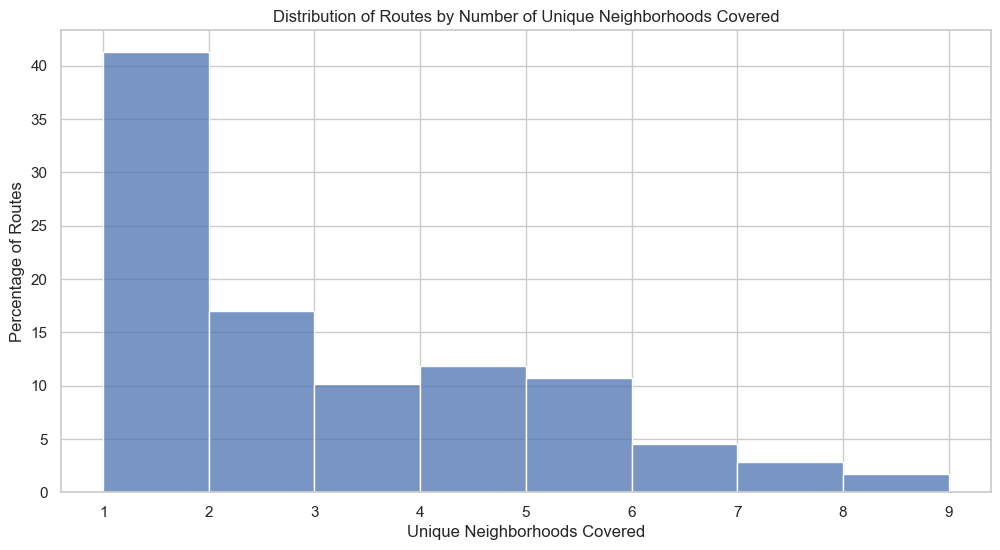

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

coverage_by_route = bus_stops_expanded.groupby('Routes')['Neighborhood'].nunique().reset_index()
coverage_by_route = coverage_by_route[:-1]
coverage_by_route.columns = ['Route ID', 'Unique Neighborhoods Covered']

plt.figure(figsize=(12, 6))
sns.histplot(coverage_by_route['Unique Neighborhoods Covered'], bins=range(1, coverage_by_route['Unique Neighborhoods Covered'].max() + 1), stat='percent', kde=False)
plt.title('Distribution of Routes by Number of Unique Neighborhoods Covered')
plt.xlabel('Unique Neighborhoods Covered')
plt.ylabel('Percentage of Routes')
plt.xticks(range(1, coverage_by_route['Unique Neighborhoods Covered'].max() + 1))
plt.show()


In [47]:
disability_population_age_race_df = pd.read_csv('tailored_disability_age&race.csv')
columns_to_drop = disability_population_age_race_df.filter(regex=r"_MOE$", axis=1).columns
disability_population_age_race_df = disability_population_age_race_df.drop(columns=columns_to_drop)

disability_population_sex_df = disability_population_age_race_df[disability_population_age_race_df
                                                                 ["Label (Grouping)"].isin(["Total civilian noninstitutionalized population", 
                                                                                            "Male", 
                                                                                            "Female"])]
disability_population_race_df = disability_population_age_race_df[disability_population_age_race_df
                                                                  ["Label (Grouping)"].isin(["Total civilian noninstitutionalized population",
                                                                                             "White alone", 
                                                                                             "Black or African American alone", 
                                                                                             "Asian alone", "Some other race alone",
                                                                                             "Two or more races", 
                                                                                             "White alone, not Hispanic or Latino", 
                                                                                             "Hispanic or Latino (of any race)"])]
disability_population_age_df = disability_population_age_race_df[disability_population_age_race_df
                                                                 ["Label (Grouping)"].isin(["Total civilian noninstitutionalized population",
                                                                                            "Under 5 years", 
                                                                                            "5 to 17 years", 
                                                                                            "18 to 34 years", 
                                                                                            "35 to 64 years", 
                                                                                            "65 to 74 years", 
                                                                                            "75 years and over"])]


In [52]:
disability_population_neighborhood_df = pd.read_csv('disability_population_boston_neighborhood_2023.csv', comment='#')

In [58]:
disability_population_neighborhood_df['Residents_with_Disability'] = \
    disability_population_neighborhood_df['Total_Residents']*disability_population_neighborhood_df['Residents_with_Disability(%)']
disability_population_neighborhood_df['Residents_with_Disability'] = disability_population_neighborhood_df['Residents_with_Disability'].apply(lambda x: round(x))

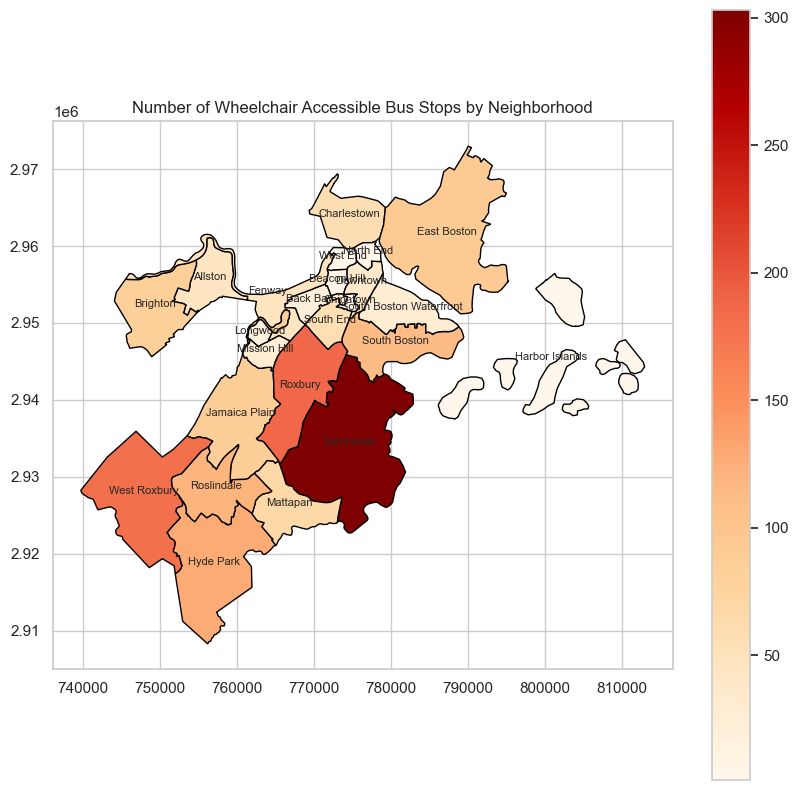

In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

bus_stops['wheelchair_accessible'] = bus_stops['wheelchair_boarding'] == 1
bus_stops_by_neighborhood = bus_stops.groupby('Neighborhood')['wheelchair_accessible'].sum().reset_index()

gdf = gpd.read_file('Census2020_BG_Neighborhoods.shp', SHAPE_RESTORE_SHX='YES')

combined_gdf = gdf.merge(bus_stops_by_neighborhood, left_on='BlockGr202', right_on='Neighborhood')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
combined_gdf.plot(column='wheelchair_accessible', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
combined_gdf.apply(lambda x: ax.annotate(text=x['Neighborhood'], xy=x.geometry.centroid.coords[0], fontsize=8, ha='center'), axis=1)
ax.set_title('Number of Wheelchair Accessible Bus Stops by Neighborhood')
plt.show()


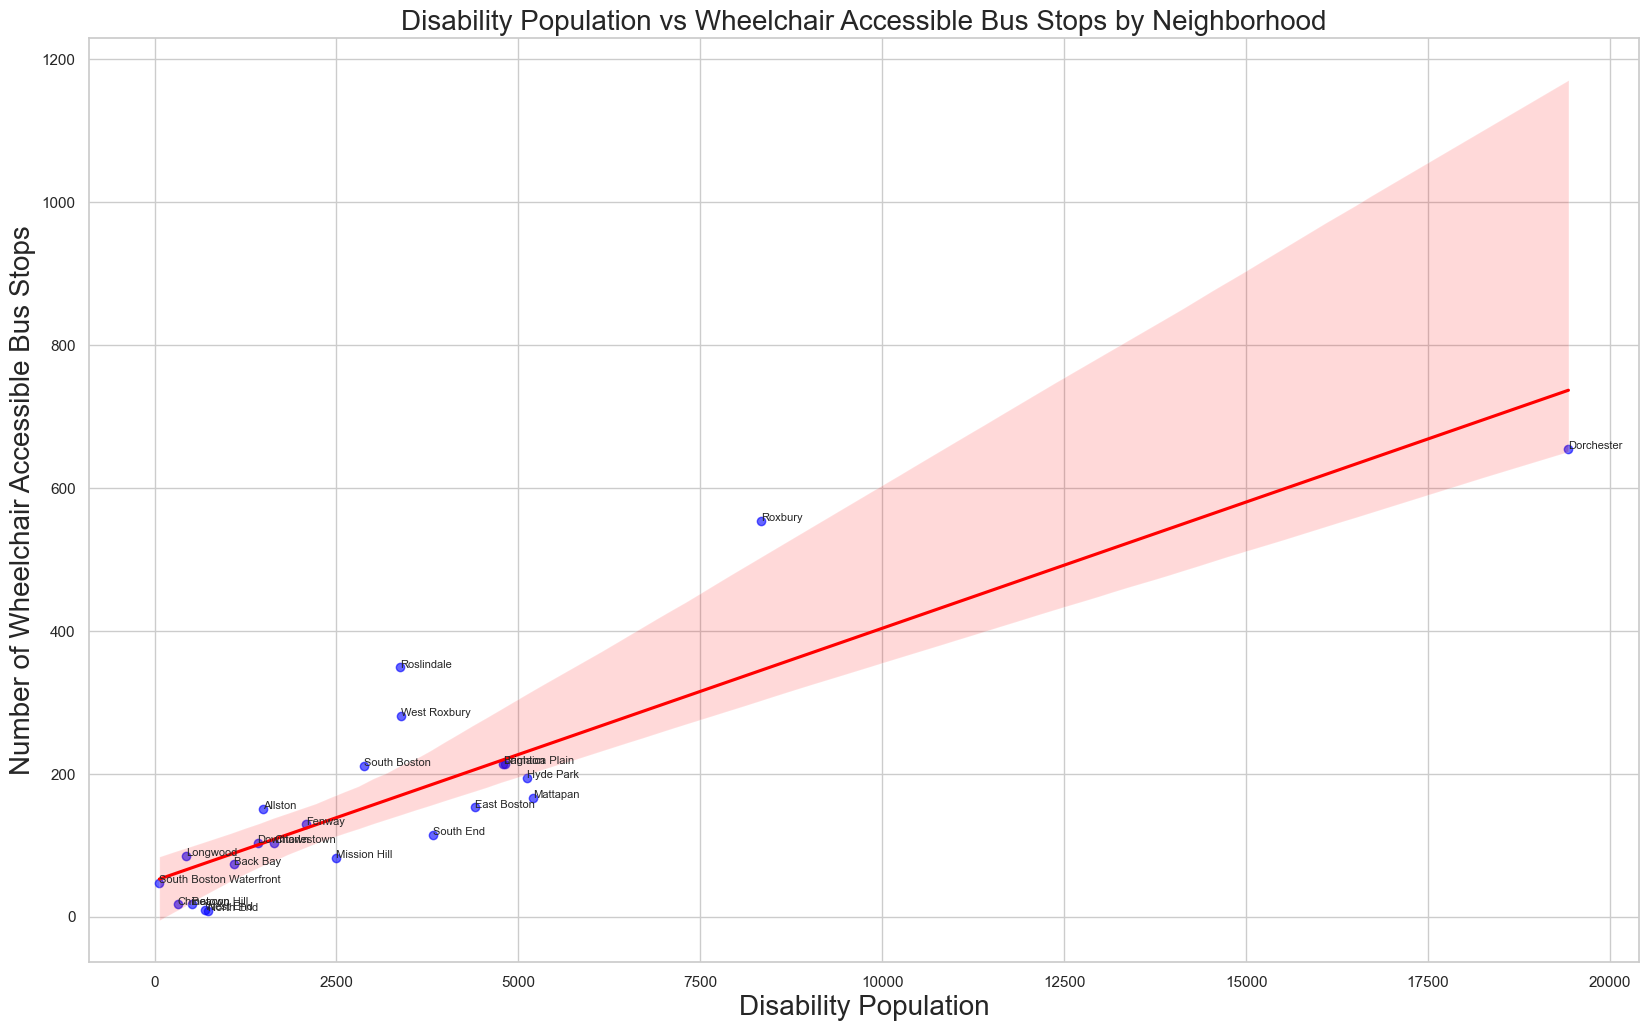

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

accessible_stops = bus_stops_expanded[bus_stops_expanded['wheelchair_boarding'] == 1]
accessible_stops_count = accessible_stops.groupby('Neighborhood').size().reset_index(name='Accessible_Stops_Count')

merged_data = pd.merge(disability_population_neighborhood_df, accessible_stops_count, on='Neighborhood')

merged_data.fillna(0, inplace=True)

plt.figure(figsize=(20, 12))
plt.scatter(merged_data['Residents_with_Disability'], merged_data['Accessible_Stops_Count'], color='blue', alpha=0.6)

sns.regplot(x='Residents_with_Disability', y='Accessible_Stops_Count', data=merged_data, scatter=False, color='red', line_kws={'label': 'Regression Line'})

plt.xlabel('Disability Population', fontsize=20)
plt.ylabel('Number of Wheelchair Accessible Bus Stops', fontsize=20)
plt.title('Disability Population vs Wheelchair Accessible Bus Stops by Neighborhood', fontsize=20)

# Decrease the size of text labels
for i, row in merged_data.iterrows():
    plt.text(row['Residents_with_Disability'], row['Accessible_Stops_Count'], row['Neighborhood'], fontsize=8)

plt.show()

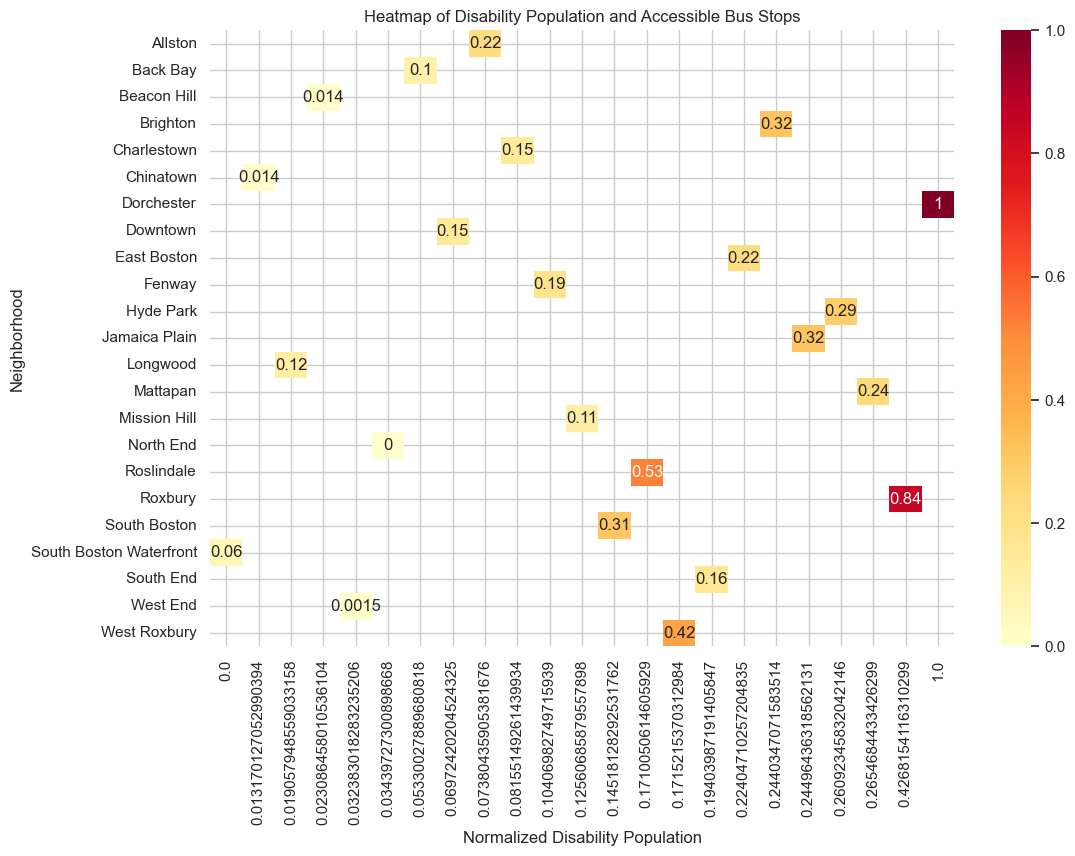

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

accessible_stops = bus_stops_expanded[bus_stops_expanded['wheelchair_boarding'] == 1]
accessible_stops_count = accessible_stops.groupby('Neighborhood').size().reset_index(name='Accessible_Stops_Count')

merged_data = pd.merge(disability_population_neighborhood_df, accessible_stops_count, on='Neighborhood')

merged_data.fillna(0, inplace=True)

# Normalize the data
scaler = MinMaxScaler()
merged_data[['Residents_with_Disability', 'Accessible_Stops_Count']] = scaler.fit_transform(merged_data[['Residents_with_Disability', 'Accessible_Stops_Count']])

# Create a pivot table using mean as the aggregation function
pivot_data = merged_data.pivot_table(index="Neighborhood", columns="Residents_with_Disability", values="Accessible_Stops_Count", aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap="YlOrRd")
plt.title('Heatmap of Disability Population and Accessible Bus Stops')
plt.ylabel('Neighborhood')
plt.xlabel('Normalized Disability Population')
plt.show()
